# K-Nearest Neighbors Regressor (KNN)

In this notebook, I use the K-Nearest Neighbors (KNN) algorithm to predict house prices for the Kaggle Housing Prices competition. KNN is a straightforward, instance-based learning method that makes predictions based on the similarity between data points.

## How it works in this project:
For each house in the test set, the algorithm finds the 'k' most similar houses in the training set, based on their features (such as size, location, and number of rooms).
The predicted price is calculated as the average price of these 'k' nearest neighbors.
The value of 'k' is a key parameter and is chosen based on model performance.

## Why KNN?
KNN does not make strong assumptions about the underlying data distribution, making it flexible for various types of data.
It is easy to implement and interpret, providing a good baseline for regression tasks like house price prediction.
Important notes for this notebook:
Since KNN relies on distance calculations, all features are scaled to ensure fair comparison.
The model’s performance is evaluated using cross-validation to select the optimal value of 'k'.



# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# training data:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

print("Train data shape: ", train_raw.shape)
print("Test data shape: ", test_raw.shape)
print(train_raw.head())

# get features and targets:
X_train = train_raw.drop(['SalePrice', 'Id'], axis=1)  # I think that only Id needs to be dropped before PCA
y_train = train_raw["SalePrice"]
X_test = test_raw.copy()  # can just copy as test.csv doesn't have the target

# separate numerical and categorical features:
numFeatures = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
catFeatures = X_train.select_dtypes(include=['object']).columns.tolist()

# utilize pipelines for preprocessing:

numPipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

catPipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# combine workflows:
preprocessor = ColumnTransformer([('numerical', numPipeline, numFeatures),
                                  ('categorical', catPipeline, catFeatures)])

# now, fit and transform data:

# use preprocessor to process train and test data:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# convert to pd dataframes:

# need to concatenate processed numerical and categorical features:
numFeature_names = numFeatures
catFeature_names = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(catFeatures)

# concatenate
totalFeatures = np.concatenate((numFeature_names, catFeature_names))

# convert to dataframes:
X_train_processed = pd.DataFrame(X_train_processed, columns=totalFeatures)
X_test_processed = pd.DataFrame(X_test_processed, columns=totalFeatures)

print("Processed Train dataset: ", X_train_processed.shape)
print("Processed Test dataset: ", X_test_processed.shape)
print(X_train_processed.head())

# write out preprocessed data:
X_train_processed.to_csv('data/train_processed.csv', index=False)
X_test_processed.to_csv('data/test_processed.csv', index=False)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold 

# Implementation of K Nearest Neighbors
Will use Euclidian and Manhattan distance, as well as weighted and unweighted KNN

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class KNN:
    def __init__(self, k, distance, weighted=False):
        self.k = k
        self.distance = distance
        self.weighted = weighted
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.pca = None
        
    # fit
    def fit(self, X, y, pca_components=None):
        # fit with PCA (if chosen):
        if pca_components is not None:
            self.pca = PCA(n_components=pca_components)
            self.X_train = self.pca.fit_transform(X)
            
        # normal fit:
        else:
            self.X_train = X if isinstance(X, list) else X
        self.y_train = y if isinstance(y, list) else y
        
        # convert to numpy arrays:
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
        
    # helper method to calculate distances:
    def calculateDistance(self, p1, p2):
        p1 = np.array(p1, dtype=float)
        p2 = np.array(p2, dtype=float)
        
        if self.distance.lower() == 'manhattan':
            return np.sum(np.abs(p1 - p2))
        
        elif self.distance.lower() == 'euclidean':
            return np.sqrt(np.sum((p1 - p2) ** 2))
        
        elif self.distance.lower() == 'chebyshev':
            return np.max(np.abs(p1 - p2))
        
        elif self.distance.lower() == 'cosine':
            from scipy.spatial.distance import cosine
            return cosine(p1, p2)
        
        elif self.distance.lower() == 'minkowski':
            return np.sum(np.abs(p1 - p2) ** 1.5) ** (1/1.5)
        
        elif self.distance.lower() == 'mahalanobis':
            V = np.linalg.inv(np.cov(self.X_train.T))
            delta = p1 - p2
            return np.sqrt(np.dot(np.dot(delta, V), delta.T))
        
        elif self.distance.lower() == 'correlation':
            return 1 - np.corrcoef(p1, p2)[0, 1]
        
        else:
            raise ValueError(f"Unknown distance metric: {self.distance}")
         
    # predict
    def predict(self, X):
        if self.pca:
            X = self.pca.transform(X)
        else:
            X = X.values if isinstance(X, pd.DataFrame) else X
            
        predictions = []
        
        for x in X:
            # compute distance:
            distances = [self.calculateDistance(x, x_train) for x_train in self.X_train]
            
            # get knns
            knn_indices = np.argsort(distances)[:self.k]
            knn_distances = [distances[i] for i in knn_indices]
            knn_prices = [self.y_train[i] for i in knn_indices]
            
            # if weighted:
            if self.weighted:
                weights = 1 / np.array(knn_distances) + 1e-8  # avoid div by 0
                prediction = np.average(knn_prices, weights=weights)
            else:
                # calculate prediction using mean price of knns:
                prediction = np.mean(knn_prices)
            
            # append prediction:
            predictions.append(prediction)
            
        return np.array(predictions)
    
    # get accuracy metrics in format [RMSE, MAE, R2]:
    def measure_accuracy(self, X, y):
        y_pred = self.predict(X)
        RMSE = np.sqrt(mean_squared_error(y, y_pred))
        MAE = mean_absolute_error(y, y_pred)
        R2 = r2_score(y, y_pred)
        return [RMSE, MAE, R2]


## Application of Model:

Utilize an 80/20 test-train split on training data and calculate error to find best configuration for optimal KNN model.

k = 2, pca = 2, weighted: True  |  RMSE = 32900.47 | MAE = 23481.70 | R2 = 0.86
k = 2, pca = 2, weighted: False  |  RMSE = 32839.48 | MAE = 23534.22 | R2 = 0.86
k = 2, pca = 3, weighted: True  |  RMSE = 34707.00 | MAE = 23302.81 | R2 = 0.84
k = 2, pca = 3, weighted: False  |  RMSE = 35047.21 | MAE = 23249.46 | R2 = 0.84
k = 2, pca = 5, weighted: True  |  RMSE = 31578.99 | MAE = 21423.99 | R2 = 0.87
k = 2, pca = 5, weighted: False  |  RMSE = 31043.66 | MAE = 21196.51 | R2 = 0.87
k = 2, pca = 10, weighted: True  |  RMSE = 32671.85 | MAE = 21028.36 | R2 = 0.86
k = 2, pca = 10, weighted: False  |  RMSE = 32170.20 | MAE = 20883.48 | R2 = 0.87
k = 2, pca = 15, weighted: True  |  RMSE = 33944.92 | MAE = 21198.75 | R2 = 0.85
k = 2, pca = 15, weighted: False  |  RMSE = 34250.42 | MAE = 21479.75 | R2 = 0.85
k = 2, pca = 25, weighted: True  |  RMSE = 36633.24 | MAE = 22449.44 | R2 = 0.83
k = 2, pca = 25, weighted: False  |  RMSE = 37015.56 | MAE = 22722.90 | R2 = 0.82
k = 2, pca = 30, weighted: T

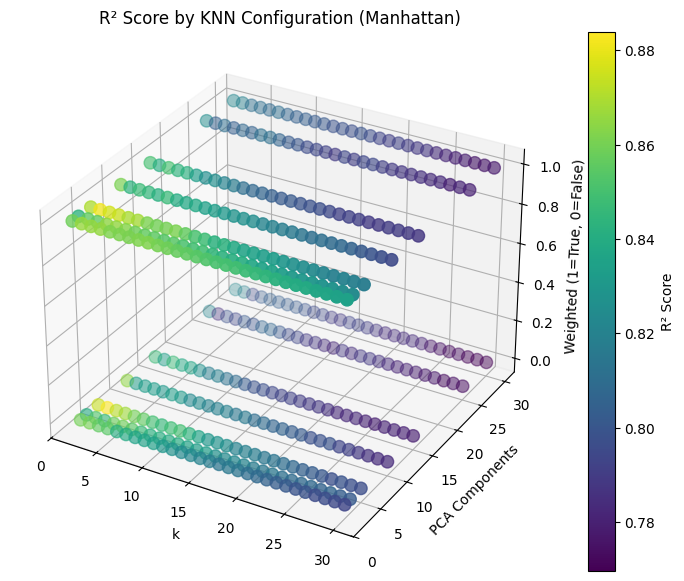

Complete.


In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# load data:
X = pd.read_csv('data/train_processed.csv')
y = pd.read_csv('data/train.csv')['SalePrice']
competition_test = pd.read_csv('data/test_processed.csv')
raw_competition_test = pd.read_csv('data/test.csv')  # don't use processed file for the Id's

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bestRMSE_stats = [None, None, None, None]  # format: RMSE, k, pca, weighted?



# find the best choice of k:

results = []

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]:
    for pca in [2, 3, 5, 10, 15, 25, 30]:
        for weighted in [True, False]:
            knn = KNN(k=k, distance='euclidean', weighted=weighted)
            knn.fit(X_train, y_train, pca_components=pca)
            [RMSE, MAE, R2] = knn.measure_accuracy(X_test, y_test)
            print(f'k = {k}, pca = {pca}, weighted: {weighted}  |  RMSE = {RMSE:.2f} | MAE = {MAE:.2f} | R2 = {R2:.2f}')
            
            results.append({
                'k': k,
                'pca': pca,
                'weighted': weighted,
                'RMSE': RMSE,
                'MAE': MAE,
                'R2': R2
            })
            
            if bestRMSE_stats[0] is None:
                bestRMSE_stats = [RMSE, MAE, R2, k, pca, weighted]
            elif bestRMSE_stats[0] > RMSE:
                bestRMSE_stats = [RMSE, MAE, R2, k, pca, weighted]

print(f'Best Configuration: k: {bestRMSE_stats[3]} | pca: {bestRMSE_stats[4]} | weighted: {bestRMSE_stats[5]} | RMSE: {bestRMSE_stats[0]:.2f} | MAE: {bestRMSE_stats[1]:.2f} | R2: {bestRMSE_stats[2]:.2f}')

# Prepare data
ks = [r['k'] for r in results]
pcas = [r['pca'] for r in results]
weighteds = [1 if r['weighted'] else 0 for r in results]  # convert bool to int for color
R2s = [r['R2'] for r in results]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(ks, pcas, weighteds, c=R2s, cmap='viridis', s=80)

ax.set_xlabel('k')
ax.set_ylabel('PCA Components')
ax.set_zlabel('Weighted (1=True, 0=False)')
plt.title('R² Score by KNN Configuration (Manhattan)')

cbar = plt.colorbar(sc)
cbar.set_label('R² Score')

plt.show()

# make prediction of test data using optimal model:

# optimal Manhattan configuration: k = 3 | 2 PCA components | weighted
# optimal Chebyshev configuration: k = 4 | 5 PCA components | weighted

"""

knn_manhattan = KNN(k=4, distance='manhattan', weighted=True)
knn_manhattan.fit(X_train, y_train, pca_components=5)
knn_manhattan_pred = knn_manhattan.predict(competition_test)

knn_chebyshev = KNN(k=4, distance='chebyshev', weighted=True)
knn_chebyshev.fit(X_train, y_train, pca_components=5)
knn_chebyshev_pred = knn_chebyshev.predict(competition_test)

knn_euclidean = KNN(k=3, distance='euclidean', weighted=True)
knn_euclidean.fit(X_train, y_train, pca_components=5)
knn_euclidean_pred = knn_euclidean.predict(competition_test)

knn_cosine = KNN(k=9, distance='cosine', weighted=True)
knn_cosine.fit(X_train, y_train, pca_components=5)
knn_cosine_pred = knn_cosine.predict(competition_test)

knn_minkowski = KNN(k=3, distance='minkowski', weighted=False)
knn_minkowski.fit(X_train, y_train, pca_components=5)
knn_minkowski_pred = knn_minkowski.predict(competition_test)

# write out predictions:

chebyshevDF = pd.DataFrame({'Id': raw_competition_test['Id'],
                            'SalePrice': knn_chebyshev_pred})
chebyshevDF.to_csv('data/chebyshev_prediction.csv', index=False)

manhattanDF = pd.DataFrame({'Id': raw_competition_test['Id'], 
                            'SalePrice': knn_manhattan_pred})
manhattanDF.to_csv('data/manhattan_prediction.csv', index=False)

euclideanDF = pd.DataFrame({'Id': raw_competition_test['Id'],
                            'SalePrice': knn_euclidean_pred})
euclideanDF.to_csv('data/euclidean_prediction.csv', index=False)

cosineDF = pd.DataFrame({'Id': raw_competition_test['Id'],
                            'SalePrice': knn_cosine_pred})
cosineDF.to_csv('data/cosine_prediction.csv', index=False)

minkowskiDF = pd.DataFrame({'Id': raw_competition_test['Id'],
                            'SalePrice': knn_minkowski_pred})
minkowskiDF.to_csv('data/minkowski_prediction.csv', index=False)

"""







print("Complete.")